<a href="https://colab.research.google.com/github/Belac44/Deep-Learning/blob/main/TB_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
from skimage.io import imread
from skimage.color import rgb2gray
from PIL import Image

In [167]:
normal_dir = "Normal/"
tb_dir = "Tuberculosis/"

normal_img = []
tb_img = []

normal_img.extend(glob.glob(normal_dir + '*.' + 'png'))
tb_img.extend(glob.glob(tb_dir + '*.' + 'png'))

In [168]:
train = []

for img in normal_img:
  train.append((img, 0))

for img in tb_img:
  train.append((img, 1))

In [169]:
train_data = pd.DataFrame(train, columns=["Image", "Label"])
train_data.head()

,Image,Label
0,Normal/Normal-252.png,0
1,Normal/Normal-203.png,0
2,Normal/Normal-251.png,0
3,Normal/Normal-118.png,0
4,Normal/Normal-37.png,0


In [170]:
train_data.groupby("Label").count()

,Image
Label,
0,300
1,300


## Pre Processing

In [199]:
def preprocess_image(image):
  img = Image.open(image)
  img = img.resize((150, 150))
  sRGB_array = np.asarray(img)
  img_gray = rgb2gray(sRGB_array)
  img_gray = img_gray/255
  return img_gray

def preprocess_image2(image):
  img = cv2.imread(str(image))
  img = cv2.resize(img, (28,28))
  if img.shape[2] ==1:
      img = np.dstack([img, img, img])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img=np.array(img)
  img = img/255
  return img

In [172]:
from tqdm import tqdm

train_data = []
train_labels = []

from keras.utils.np_utils import to_categorical



for img in tqdm(normal_img):
    img = preprocess_image2(img)
    label = "Normal"
    train_data.append(img)
    train_labels.append(label)
                      
        
for img in tqdm(tb_img):
    img = preprocess_image2(img)
    label = "Tuberculosis"
    train_data.append(img)
    train_labels.append(label)
    


train_data1 = np.array(train_data)
train_labels1 = np.array(train_labels)

print("Total number of validation examples: ", train_data1.shape)
print("Total number of labels:", train_labels1.shape)

100%|██████████| 300/300 [00:01<00:00, 196.20it/s]

Total number of validation examples:  (600, 28, 28, 3)
Total number of labels: (600,)


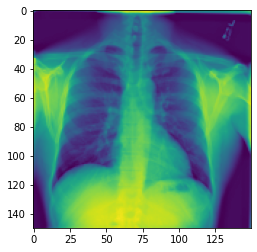

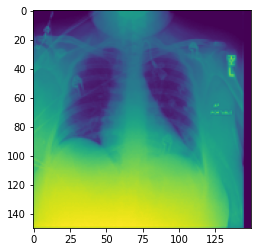

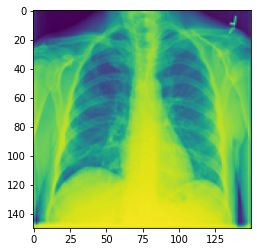

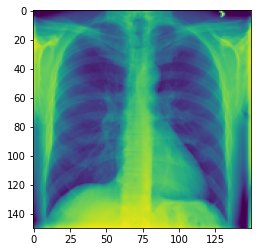

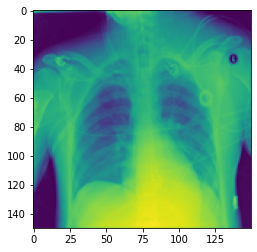

In [210]:
for i in range(5):
  img = Image.open(normal_img[i])
  img = img.resize((150, 150))
  sRGB_array = np.asarray(img)
  img_gray = rgb2gray(sRGB_array)
  img_gray = img_gray/255
  plt.imshow(img_gray)
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """


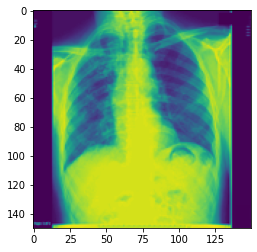

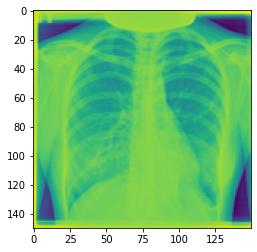

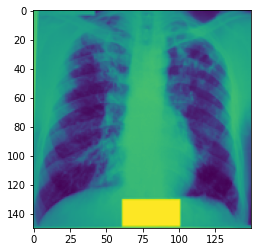

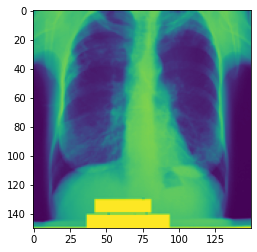

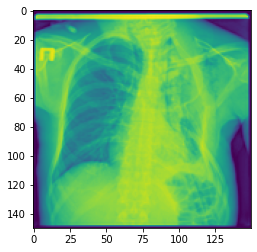

In [211]:
for i in range(5):
  img = Image.open(tb_img[i])
  img = img.resize((150, 150))
  sRGB_array = np.asarray(img)
  img_gray = rgb2gray(sRGB_array)
  img_gray = img_gray/255
  plt.imshow(img_gray)
  plt.show()

In [173]:
train_data1.shape

(600, 28, 28, 3)

In [174]:
train_labels1 = pd.DataFrame(train_labels1, columns=[ 'label'],index=None)
train_labels1.head()

,label
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal


In [175]:
train_labels1['label']=train_labels1['label'].map({'Normal':0,'Tuberculosis':1})
train_labels1['label'].unique()

array([0, 1])

In [176]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
train_rows=len(train_data1)
train_data1 = train_data1.reshape(train_rows,-1)
train_data2, train_labels2 = smt.fit_resample(train_data1, train_labels1)

In [177]:
train_data2 =train_data2.reshape(-1,28,28, 3)

In [178]:
train_data2.shape

(600, 28, 28, 3)

In [179]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data2, train_labels2, test_size=0.13, random_state=42)

In [180]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(28, 28, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
      
  ]
)

In [185]:
import tensorflow as tf
from tensorflow.keras import  layers, models

def create_model():
  model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,3)) ,
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu')
    
])
  model.add(layers.Flatten())
  model.add(layers.Dense(640, activation='tanh'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(564, activation='tanh'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64, activation='tanh'))
  model.add(layers.Dense(64, activation='sigmoid'))
  model.add(layers.Dense(2))

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [182]:
model = create_model()

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 4, 4, 64)          16448     
                                                                 
 flatten_15 (Flatten)        (None, 1024)            

In [183]:
checkpoint_path = "training/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
model.fit(np.array(X_train), np.array(y_train), epochs=200, validation_data=(np.array(X_test), np.array(y_test)),callbacks=[cp_callback] )


Epoch 1/200
10/17 [================>.............] - ETA: 0s - loss: 0.6752 - accuracy: 0.5750
Epoch 1: saving model to training/cp.ckpt
17/17 [==============================] - 1s 20ms/step - loss: 0.6876 - accuracy: 0.5632 - val_loss: 0.5712 - val_accuracy: 0.7436
Epoch 2/200
12/17 [====================>.........] - ETA: 0s - loss: 0.5401 - accuracy: 0.7578
Epoch 2: saving model to training/cp.ckpt
17/17 [==============================] - 0s 10ms/step - loss: 0.5130 - accuracy: 0.7701 - val_loss: 0.2583 - val_accuracy: 0.9231
Epoch 3/200
12/17 [====================>.........] - ETA: 0s - loss: 0.3791 - accuracy: 0.8307
Epoch 3: saving model to training/cp.ckpt
17/17 [==============================] - 0s 9ms/step - loss: 0.3764 - accuracy: 0.8352 - val_loss: 0.4603 - val_accuracy: 0.7949
Epoch 4/200
12/17 [====================>.........] - ETA: 0s - loss: 0.3302 - accuracy: 0.8594
Epoch 4: saving model to training/cp.ckpt
17/17 [==============================] - 0s 9ms/step - loss: 0.

In [188]:
model = create_model()
model.load_weights(checkpoint_path)
loss, acc = model.evaluate(X_train, y_train, verbose=2)

17/17 - 0s - loss: 1.3800e-04 - accuracy: 1.0000 - 252ms/epoch - 15ms/step
